<a href="https://colab.research.google.com/github/mdpetrov/pref-ai/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection of anomalies and fraudlent activity in binary options trading data

In this analysis I did an investigation in binary options trading transactions in order to find anomalies and fraudlent activity.


## Loading packages and reading the data

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans, OPTICS
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
import datetime
import gc

In [39]:
trades = pd.read_csv('/content/drive/MyDrive/quadcode_2023_test/data/AntiFraudAnalystTradeData.csv')
print(trades.shape)
trades.head()

(1764494, 17)


,Unnamed: 0,id,user_id,registration_date,fin_instrument,instrument_type,instrument_direction,create_at,close_at,instrument_expiration,close_reason,platform,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled
0,0,9653594472,585118157,2019-04-05 17:12:46.000000,XRPUSD,turbo-option,call,2022-06-17 19:41:03.216000+00:00,2022-06-17 19:42:00+00:00,2022-06-17 19:42:00+00:00,expired,Unknown platform,0.314705,0.314955,0.314705,22.610000,19.210000
1,1,9641975390,1456695825,2021-08-12 02:28:57.928101,XRPUSD,turbo-option,call,2022-06-14 00:23:15.137000+00:00,2022-06-14 00:24:00+00:00,2022-06-14 00:24:00+00:00,expired,WebGL,0.308125,0.307895,0.308125,0.390000,-0.390000
2,2,15634194734,220188644,2017-03-25 01:22:50.000000,XRPUSD,digital-option,call,2022-06-13 20:18:13.091000+00:00,2022-06-13 20:19:00+00:00,2022-06-13 20:19:00+00:00,expired,WinGL,0.323725,0.323695,0.323725,0.391288,-0.391288
3,3,15639824168,1722200363,2022-06-14 21:47:25.600786,ETHUSD,digital-option,put,2022-06-14 20:17:00.316000+00:00,2022-06-14 20:18:00+00:00,2022-06-14 20:18:00+00:00,expired,WebGL,1205.656500,1203.599000,1205.656500,3.900220,3.704580
4,4,9642044367,984111245,2020-07-29 22:30:11.776766,BTCUSD,turbo-option,call,2022-06-14 00:50:41.887000+00:00,2022-06-14 00:52:00+00:00,2022-06-14 00:52:00+00:00,expired,WinGL,22227.305000,22185.852000,22227.305000,0.390000,-0.390000


In [40]:
trades.columns

Index(['Unnamed: 0', 'id', 'user_id', 'registration_date', 'fin_instrument',
       'instrument_type', 'instrument_direction', 'create_at', 'close_at',
       'instrument_expiration', 'close_reason', 'platform', 'open_quote',
       'close_quote', 'instrument_strike', 'initial_investment_enrolled',
       'pnl_total_enrolled'],
      dtype='object')

Technical function for transforming dates

In [41]:
def transform_to_unix(vector, is_date=False):
    unix_date = datetime.date(year=1970, month=1, day=1)
    unix_datetime = datetime.datetime(year=1970, month=1, day=1, hour=0, minute=0, second=0, microsecond=0)
    if is_date:
        return (vector.astype('datetime64[ns]').dt.date - unix_date).dt.total_seconds()
    else:
        return (vector.astype('datetime64[ns]') - unix_datetime).dt.total_seconds()

Adding new features and transforming string variables to dummies

In [42]:
trades['trade_duration'] = (trades.close_at.astype('datetime64[ns]') - trades.create_at.astype('datetime64[ns]')).dt.total_seconds()
trades['option_duration'] = (trades.instrument_expiration.astype('datetime64[ns]') - trades.create_at.astype('datetime64[ns]')).dt.total_seconds()
trades['positive_pnl'] = 1*(trades['pnl_total_enrolled'] > 0)
trades['profitability'] = trades['pnl_total_enrolled'] / trades['initial_investment_enrolled']
for v in ['fin_instrument', 'instrument_type', 'instrument_direction', 'close_reason', 'platform']:
    tmp = pd.get_dummies(trades[v], prefix=v)
    trades[tmp.columns] = tmp

trades['create_at'] = trades['create_at'].astype('datetime64[ns]')
trades['create_at_dt'] = trades['create_at'].dt.date
trades['registration_date'] = trades['registration_date'].astype('datetime64[ns]')
trades.sort_values(['user_id', 'create_at'], inplace=True)
trades['trade_freq'] = trades.groupby(['user_id', 'create_at_dt'])['create_at'].diff(1).dt.total_seconds()

trades.columns

Index(['Unnamed: 0', 'id', 'user_id', 'registration_date', 'fin_instrument',
       'instrument_type', 'instrument_direction', 'create_at', 'close_at',
       'instrument_expiration', 'close_reason', 'platform', 'open_quote',
       'close_quote', 'instrument_strike', 'initial_investment_enrolled',
       'pnl_total_enrolled', 'trade_duration', 'option_duration',
       'positive_pnl', 'profitability', 'fin_instrument_BTCUSD',
       'fin_instrument_EOSUSD', 'fin_instrument_ETHUSD',
       'fin_instrument_LTCUSD', 'fin_instrument_XRPUSD',
       'instrument_type_digital-option', 'instrument_type_turbo-option',
       'instrument_direction_call', 'instrument_direction_put',
       'close_reason_canceled', 'close_reason_expired', 'close_reason_sold',
       'platform_Android', 'platform_Android Facebook',
       'platform_Android Vertical', 'platform_Android pwa for iqoption',
       'platform_CapitalBear.Android', 'platform_CapitalBear.AndroidX',
       'platform_CapitalBear.WebGL', 'pl

Here:

* trade_duration -- actual time of trader kept the option in seconds;
* option_duration -- maximum option duration in seconds;
* profitability -- ratio of profit (loss) to investment;
* trade_freq -- amount of time between previous transaction in seconds;

Other variables are technical and needed for future aggregation.


In [43]:
devices = pd.read_csv('/content/drive/MyDrive/quadcode_2023_test/data/AntiFraudAnalystUserDevices.csv')
print(devices.shape)
devices.head()

(6245842, 3)


,Unnamed: 0,user_id,device_id
0,0,1185175017,a3037561a43a726fdbd4168b4e2e7df7
1,1,1245468614,92e5e634-9d56-4aa9-9dd3-9cca03da117e
2,2,698383907,fdc12321-6bfc-4647-9bc8-fd8afb2ea519
3,3,597374921,96cdb18c-c2cd-4485-a9be-eb24ac5a7d70
4,4,1573954525,382cfedb2d3dcc74bb7b1aab54d6f26f


## Transactions exploratory data analysis
First, I took a look at several features that gave me a basic understanding of the data I'm working with.

For now I'm only investigating on transactions, I'll look at devices later when it comes to users.

### Dates

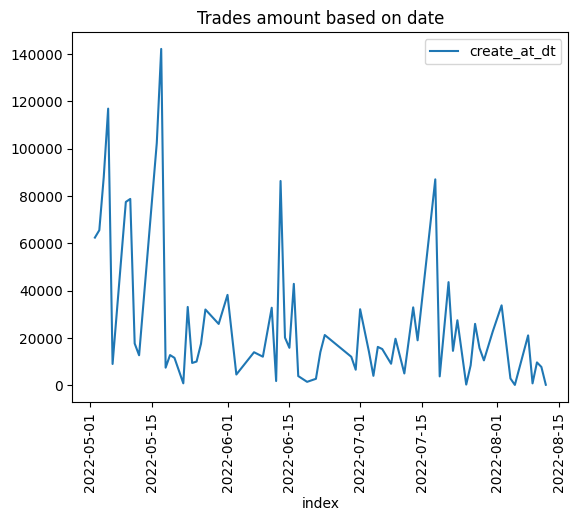

In [44]:
trades['create_at_dt'].value_counts().reset_index().plot(x='index', y='create_at_dt')
plt.xticks(rotation=90)
plt.title('Trades amount based on date')
plt.show()

So, I have transactions from 01.05.2022 to 15.08.2022. As I could see there are some spikes on the graph that could possible mean either new clients coming our platform or old clients returning to us. It order to understand this I made another graph.

Text(0.5, 1.0, 'Users registrations per day')

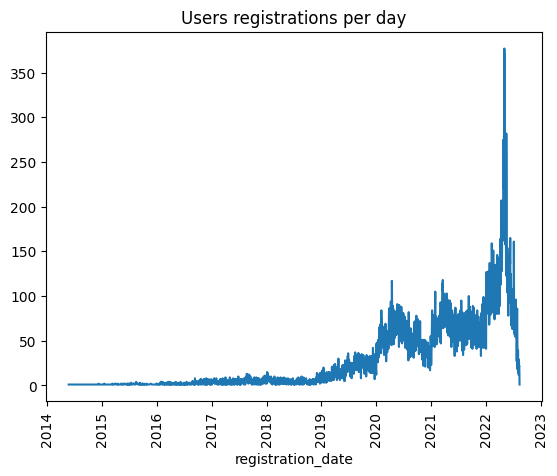

In [45]:
tmp = pd.DataFrame(trades['registration_date'].dt.date, index=trades.index)
tmp['user_id'] = trades['user_id']
tmp.groupby('registration_date')['user_id'].agg(pd.Series.nunique).plot(x='index', y='user_id')
plt.xticks(rotation=90)
plt.title('Users registrations per day')

Text(0.5, 1.0, 'Users activity (transaction count) depending on registration date')

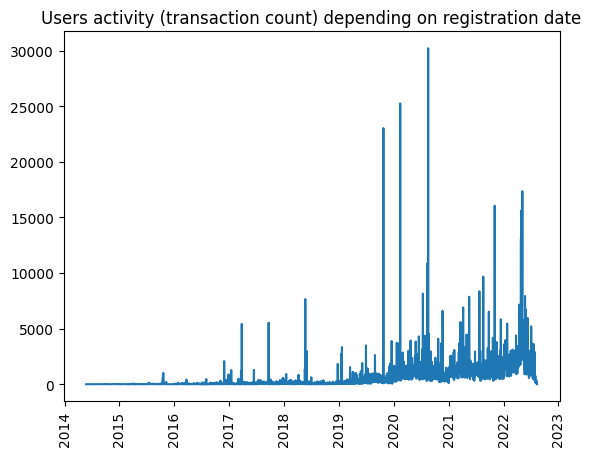

In [46]:
tmp = pd.DataFrame(trades['registration_date'].dt.date, index=trades.index)
tmp['registration_date'].value_counts().plot()
plt.xticks(rotation=90)
plt.title('Users activity (transaction count) depending on registration date')

As I can see the amount of user registrations per day was pretty flat until 2020 year. Then it started to grow in 2020, 2021 and got to the top of 350 users per day in 2022 after whet it started to move down.

### Strings

<Figure size 640x480 with 0 Axes>

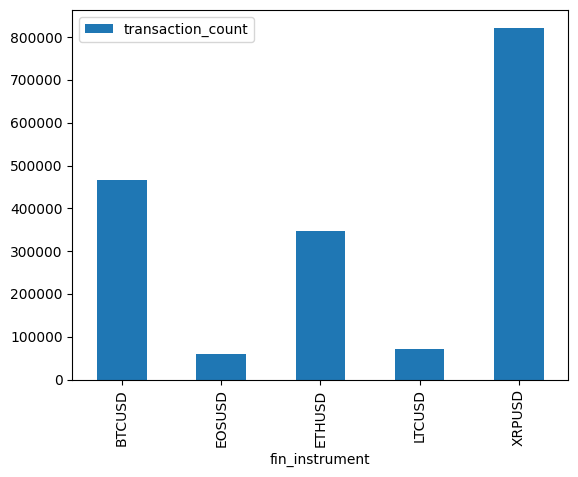

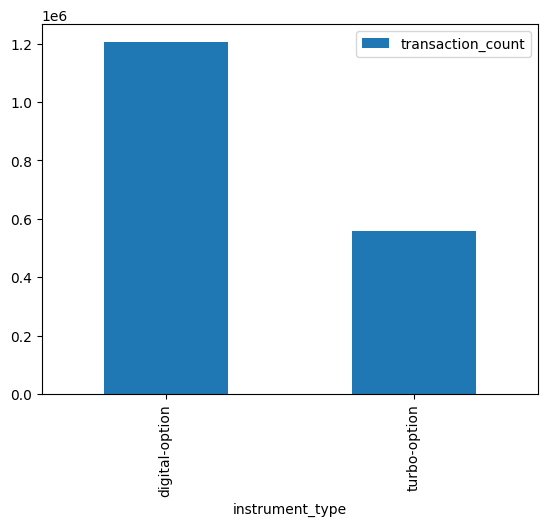

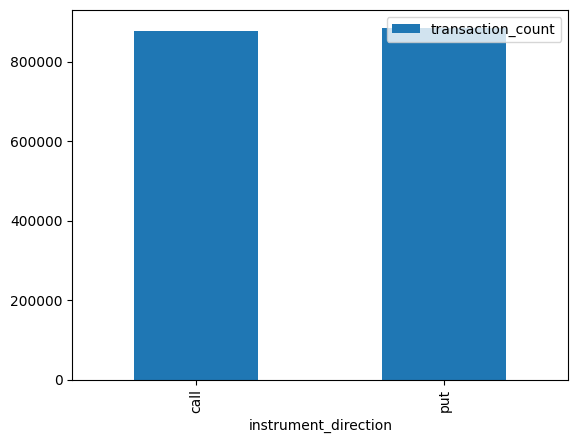

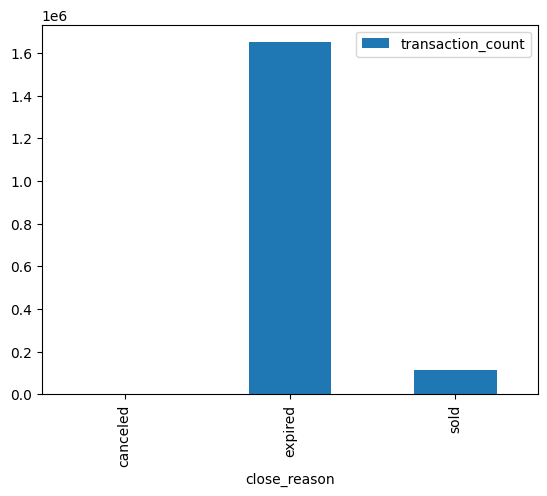

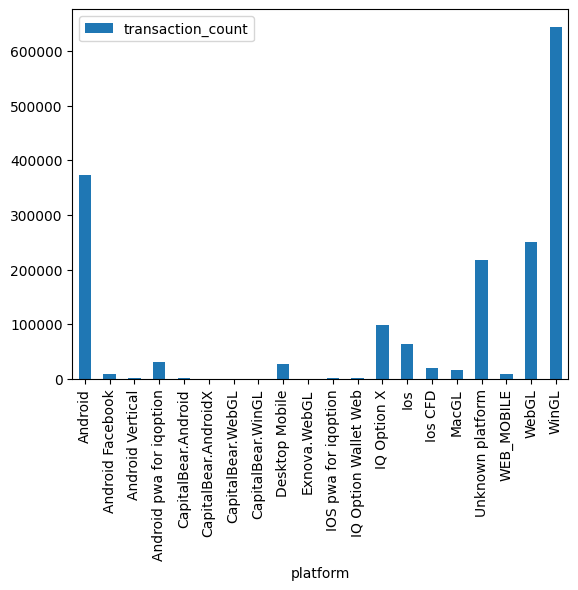

In [47]:
plt.clf()
# fig, ax = plt.subplots(2,3, figsize=(10,10))
# ax = ax.reshape(-1)
for i,v in enumerate(['fin_instrument', 'instrument_type', 'instrument_direction', 'close_reason', 'platform']):
    trades.groupby(v, as_index=False)[['id']].count().rename(columns={'id':'transaction_count'}).plot(kind='bar', x=v, y='transaction_count')
    # ax[i].bar(x=dg[v], height=dg['transaction_count'])
    # ax[i].set_title(v)
    # ax[i].set_xticklabels(dg[v], rotation = 90)
plt.show()

As I could see from the graphs above the most popular instrument is XRPUSD. Type of the instrument is generally digital option. The option direction statistics is equal between put and call. Close reason is mainly option expiration. And top platforms are WinGL, Android and WebGL.

Then I looked at finance variables: investments and profit/loss.

### Numerics

In [48]:
for v in ['initial_investment_enrolled', 'pnl_total_enrolled']:
    print(trades[v].quantile([x/10 for x in range(11)]))

0.0       0.360000
0.1       0.390402
0.2       0.406486
0.3       0.626225
0.4       0.980000
0.5       1.056545
0.6       1.948860
0.7       2.900000
0.8       5.000000
0.9      13.490000
1.0    1608.910000
Name: initial_investment_enrolled, dtype: float64
0.0   -1558.320000
0.1      -4.226257
0.2      -1.740000
0.3      -0.813964
0.4      -0.395178
0.5       0.320000
0.6       0.387469
0.7       0.881636
0.8       1.771030
0.9       5.126098
1.0    1544.560000
Name: pnl_total_enrolled, dtype: float64


Here we could already see outliers. The majority of trades has investment amount of no more than $1$ and the return is no more than $0.32$. Also I mentioned huge maximum value of investments and both maximum and minimum values of profit. I should definetely look at these cases.

<Axes: >

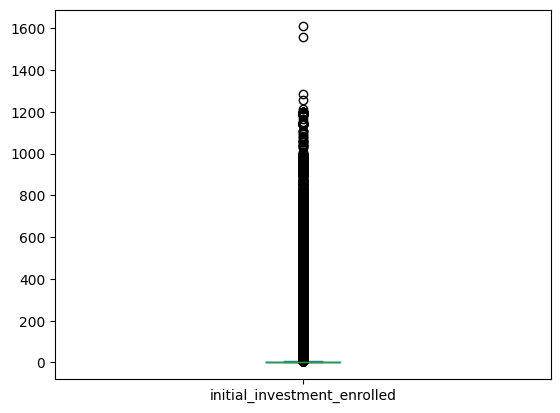

In [49]:
trades[['initial_investment_enrolled']].plot(kind='box')

## Traders profiles analysis
After transactions EDA I decided to search for anomalies in traders behavior during current period. First of all I generated new features and transform string variables to dummies in order to make some statistics later.


### User profile creation

In [50]:
res = {}
dg = trades.groupby('user_id')
res['registration_date'] = dg['registration_date'].max().astype('datetime64').dt.date
res['transaction_cnt'] = dg['id'].count()
res['pos_transaction_share'] = dg['positive_pnl'].sum() / res['transaction_cnt']
res['activity_day_cnt'] = dg['create_at_dt'].agg(pd.Series.nunique)
res['transactions_per_day'] = res['transaction_cnt'] / res['activity_day_cnt']
res['fin_instrument_cnt'] = dg['fin_instrument'].agg(pd.Series.nunique)
for x in ['fin_instrument', 'instrument_type', 'instrument_direction', 'close_reason', 'platform']:
    columns = [x[0] for x in trades.columns.str.findall('{}_.*'.format(x)) if len(x) > 0]
    for v in columns[:-1]:
        res['{}_share'.format(v)] = dg[v].sum() / res['transaction_cnt']
res['trade_frequency_mean'] = dg['trade_freq'].mean()
res['trade_frequency_var'] = dg['trade_freq'].var()
res['trade_duration_mean'] = dg['trade_duration'].mean()
res['trade_duration_var'] = dg['trade_duration'].var()
res['option_duration_mean'] = dg['option_duration'].mean()
res['option_duration_var'] = dg['option_duration'].var()
res['investment_mean'] = dg['initial_investment_enrolled'].mean()
res['investment_var'] = dg['initial_investment_enrolled'].var()
res['investment_sum'] = dg['initial_investment_enrolled'].sum()
res['profit_mean'] = dg['pnl_total_enrolled'].mean()
res['profit_var'] = dg['pnl_total_enrolled'].var()
res['profit_sum'] = dg['pnl_total_enrolled'].sum()
res['profitability_mean'] = dg['profitability'].mean()
res['profitability_var'] = dg['profitability'].var()
res = pd.DataFrame(res)
users = res.copy()
users['device_cnt'] = devices.groupby('user_id')['device_id'].count()
users['registration_date'] = (users.registration_date - users.registration_date.min()).dt.total_seconds()
users.device_cnt.fillna(0, inplace=True)
users.trade_frequency_mean.fillna(-1, inplace=True)
users.trade_frequency_var.fillna(0, inplace=True)

print(users.columns)
users.head()

<ipython-input-50-23e685ca1ed6>:3: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  res['registration_date'] = dg['registration_date'].max().astype('datetime64').dt.date


Index(['registration_date', 'transaction_cnt', 'pos_transaction_share',
       'activity_day_cnt', 'transactions_per_day', 'fin_instrument_cnt',
       'fin_instrument_BTCUSD_share', 'fin_instrument_EOSUSD_share',
       'fin_instrument_ETHUSD_share', 'fin_instrument_LTCUSD_share',
       'instrument_type_digital-option_share',
       'instrument_direction_call_share', 'close_reason_canceled_share',
       'close_reason_expired_share', 'platform_Android_share',
       'platform_Android Facebook_share', 'platform_Android Vertical_share',
       'platform_Android pwa for iqoption_share',
       'platform_CapitalBear.Android_share',
       'platform_CapitalBear.AndroidX_share',
       'platform_CapitalBear.WebGL_share', 'platform_CapitalBear.WinGL_share',
       'platform_Desktop Mobile_share', 'platform_Exnova.WebGL_share',
       'platform_IOS pwa for iqoption_share',
       'platform_IQ Option Wallet Web_share', 'platform_IQ Option X_share',
       'platform_Ios_share', 'platform_Ios C

,registration_date,transaction_cnt,pos_transaction_share,activity_day_cnt,transactions_per_day,fin_instrument_cnt,fin_instrument_BTCUSD_share,fin_instrument_EOSUSD_share,fin_instrument_ETHUSD_share,fin_instrument_LTCUSD_share,...,option_duration_var,investment_mean,investment_var,investment_sum,profit_mean,profit_var,profit_sum,profitability_mean,profitability_var,device_cnt
user_id,,,,,,,,,,,,,,,,,,,,,
2352922,0.0,2,0.5000,1,2.0,1,0.0,0.0,0.0,0.00,...,699.417401,0.790000,0.000000,1.58000,-0.050000,1.095200,-0.100000,-0.063291,1.754847,9.0
2850718,2937600.0,3,0.0000,1,3.0,1,0.0,0.0,0.0,0.00,...,20549.323596,3.000000,0.000000,9.00000,-2.006172,2.963084,-6.018515,-0.668724,0.329232,149.0
3283384,4752000.0,2,0.0000,1,2.0,1,1.0,0.0,0.0,0.00,...,1324.271648,1.000000,0.000000,2.00000,-1.000000,0.000000,-2.000000,-1.000000,0.000000,11.0
3726424,6307200.0,4,0.5000,1,4.0,1,1.0,0.0,0.0,0.00,...,8779.500603,1.750000,0.250000,7.00000,-0.699661,2.336699,-2.798646,-0.230856,0.902772,64.0
3994731,7171200.0,16,0.6875,2,8.0,2,0.0,0.0,0.0,0.25,...,330.646636,1.993539,0.822711,31.89662,0.668442,4.005635,10.695077,0.320789,0.845819,1.0


Here I aggregated all features I have and created a dataframe that contains all information on the user level including amount of devices user used. Because I don't have any information about device type or date when it was used, I could only look for count of it. Also I'm using `fillna` function to replace NaNs in values to numericals.

### Traders EDA
Next I'd like to look for several traders features.

#### Count of transactions

In [51]:
print(users['transaction_cnt'].mean())
users.loc[:, ['transaction_cnt']].quantile([0, 0.01, 0.05] + [x / 10 for x in range(1, 10)] + [0.95, 0.99, 1])

21.590362920000977


,transaction_cnt
0.00,1.0
0.01,1.0
0.05,1.0
0.10,1.0
0.20,1.0
0.30,2.0
0.40,3.0
0.50,4.0
0.60,6.0
0.70,10.0


<Axes: >

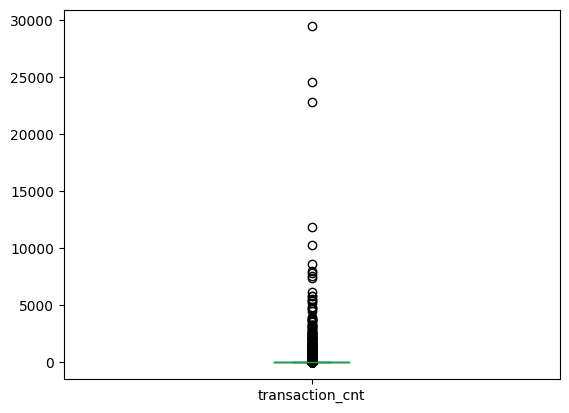

In [52]:
users['transaction_cnt'].plot(kind='box')

Based on quantile distribution I could identify 3 groups of trades:
1. Small transactions (< 10) -- 70%
2. Medium transactions (10-60) -- 25%
3. High transactions (60+) - 5%

Only 5% of traders are regular!

#### Count of activity days

Here I looked through the count of days in which trader made at least one transaction.

In [53]:
users.loc[:, ['activity_day_cnt']].quantile([0, 0.01, 0.05] + [x / 10 for x in range(1, 10)] + [0.95, 0.99, 1])

,activity_day_cnt
0.00,1.0
0.01,1.0
0.05,1.0
0.10,1.0
0.20,1.0
0.30,1.0
0.40,1.0
0.50,1.0
0.60,2.0
0.70,2.0


As I can see most of the users was active only once during the investigation period. Only $1\%$ of users was active more than 12 days and maximum is only 51 days (of about 100 days in total).

#### Unusual user statistics

Then I'm going to look for the traders with large amount of transactions and investment dispersion.

In [54]:
users.query('transaction_cnt >= 100')['investment_var'].quantile([x / 10 for x in range(1, 10)] + [0.95, 0.99, 1])

0.10         0.019755
0.20         0.116042
0.30         0.336869
0.40         0.856213
0.50         2.025315
0.60         6.322012
0.70        19.985758
0.80        70.678988
0.90       511.986874
0.95      1688.266571
0.99     23027.203308
1.00    156291.460360
Name: investment_var, dtype: float64

I could see that there are several users with very high investment dispersion. These traders probably made several transactions with much more investment sum than they usually do. I decided to look at these traders more closely.

In [55]:
tmp = users.query('(transaction_cnt >= 100) & (investment_var >= 23000)').index
trades.set_index('user_id').loc[tmp, :].groupby('user_id')['initial_investment_enrolled'].max()

user_id
151796736      830.530000
593668803      879.080000
682618586      951.100000
706253093     1151.500000
737584705     1060.850000
778761464     1039.890000
819030420     1200.370000
853914282      999.670000
872687114     1608.910000
892182733      846.180000
927447287      651.420000
977296333      958.570000
999089325     1140.310000
1002166945     793.500000
1015944150    1187.230000
1054019889    1140.000000
1059641609     951.100000
1177413406     810.010000
1189984146    1184.831325
1203194070     749.620000
1279288400    1199.510000
1302201082    1005.370000
1511784534    1000.000000
1513755659    1199.620000
1591332717     802.509190
Name: initial_investment_enrolled, dtype: float64

As I saw before on dispersion these traders have significantly greater max investment then median value. Those transactions should be double-checked as they seem to be anomaly high for these traders.

Then I decided to look for traders with unusually high profit and at the same time very low transactions count.

<Axes: >

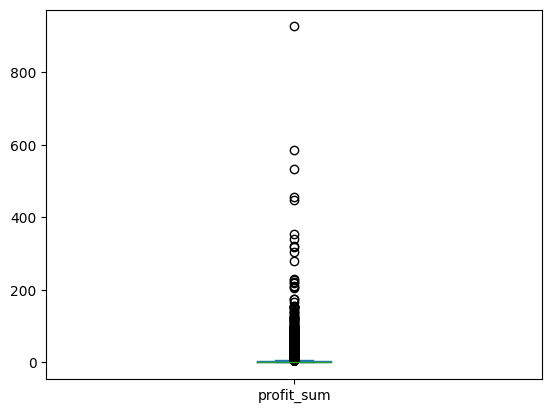

In [56]:
users.query('(transaction_cnt <= 3) & (profit_sum > 0)')['profit_sum'].plot(kind='box')

In [57]:
users.query('(transaction_cnt <= 3) & (profit_sum >= 500)')

,registration_date,transaction_cnt,pos_transaction_share,activity_day_cnt,transactions_per_day,fin_instrument_cnt,fin_instrument_BTCUSD_share,fin_instrument_EOSUSD_share,fin_instrument_ETHUSD_share,fin_instrument_LTCUSD_share,...,option_duration_var,investment_mean,investment_var,investment_sum,profit_mean,profit_var,profit_sum,profitability_mean,profitability_var,device_cnt
user_id,,,,,,,,,,,,,,,,,,,,,
957859734,193363200.0,3,1.0,3,1.0,3,0.0,0.0,0.333333,0.333333,...,195.414308,189.746911,35981.871116,569.240734,177.910355,33752.258640,533.731066,0.915027,4.003967e-03,7.0
1215489691,212630400.0,1,1.0,1,1.0,1,1.0,0.0,0.000000,0.000000,...,NaN,731.540000,NaN,731.540000,585.240000,NaN,585.240000,0.800011,NaN,170.0
1451388653,227318400.0,2,1.0,1,2.0,1,1.0,0.0,0.000000,0.000000,...,1.086338,500.000000,0.000000,1000.000000,463.337250,0.000028,926.674500,0.926675,1.125000e-10,14.0


These anomalies also should be taken into account as their investments and success maybe results of front-running fraud.

### Traders PCA analysis

Here I tried to understood are there any clusters of users that could probably be interpreted like anomalies and should I continue with traders clustering analysis.

In [61]:
pca_estimator = make_pipeline(MinMaxScaler(), PCA(n_components = 3)).fit_transform(users.query('transaction_cnt >= 2'))

# pca = PCA(n_components = 3)
components = pca_estimator
total_var = 0
for x in pca.explained_variance_ratio_:
    total_var += x
    print(round(x, 4), round(total_var, 2), sep='\t')
components = pd.DataFrame(components, index=users.query('transaction_cnt >= 2').index)

0.2015	0.2
0.1595	0.36
0.1418	0.5
0.098	0.6
0.0848	0.69
0.0771	0.76
0.0477	0.81
0.0377	0.85
0.0351	0.88
0.0217	0.9


<Figure size 640x480 with 0 Axes>

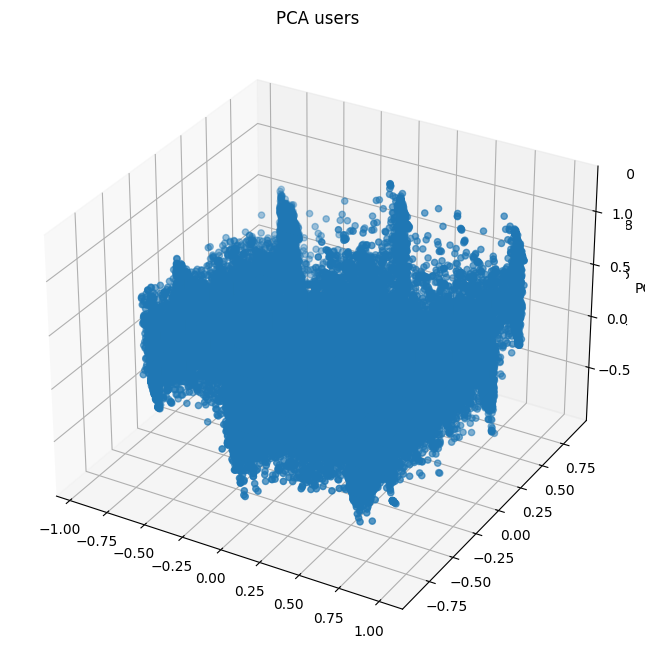

In [62]:
plt.clf()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_title("PCA users")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax = plt.axes(projection='3d')
ax.scatter3D(xs=components[0], ys=components[1], zs=components[2])
plt.show()

As I can see based on $3$ PC ($50\%$ of variance explained), there is rather hard to separate them to different clusters and find anomalies. So, I decided to move to the transaction analysis.

## Transaction cluster analysis

Now I'm going to get back to the transactions. I'm trying now to find anomalies there using almost all features that I have in original dataset and several cluster techniques.

### Sample Creation

In [21]:
x = ['create_at', 'close_at',
        'open_quote', 'close_quote', 'instrument_strike', 'initial_investment_enrolled',
       'pnl_total_enrolled', 'trade_duration', 'option_duration',
       'profitability', 'fin_instrument_BTCUSD',
       'fin_instrument_EOSUSD', 'fin_instrument_ETHUSD',
       'fin_instrument_LTCUSD', 'fin_instrument_XRPUSD',
       'instrument_type_digital-option', 'instrument_type_turbo-option',
       'instrument_direction_call', 'instrument_direction_put',
       'close_reason_canceled', 'close_reason_expired', 'close_reason_sold',
       'platform_Android', 'platform_Android Facebook',
       'platform_Android Vertical', 'platform_Android pwa for iqoption',
       'platform_CapitalBear.Android', 'platform_CapitalBear.AndroidX',
       'platform_CapitalBear.WebGL', 'platform_CapitalBear.WinGL',
       'platform_Desktop Mobile', 'platform_Exnova.WebGL',
       'platform_IOS pwa for iqoption', 'platform_IQ Option Wallet Web',
       'platform_IQ Option X', 'platform_Ios', 'platform_Ios CFD',
       'platform_MacGL', 'platform_Unknown platform', 'platform_WEB_MOBILE',
       'platform_WebGL', 'platform_WinGL', 'create_at_dt', 'trade_freq']
trades_c = trades.set_index('id').loc[:, x]
for v in ['create_at', 'close_at']:
    # trades_c[v] = (trades_c[v].astype('datetime64[ns]') - datetime.datetime(year=1970, month=1, day=1, hour=0, minute=0, second=0)).dt.total_seconds()
    trades_c[v] = transform_to_unix(trades_c[v])
trades_c['create_at_dt'] = transform_to_unix(trades_c['create_at_dt'], is_date=True)
trades_c['trade_freq'].fillna(-1, inplace=True)
trades_c.head()

,create_at,close_at,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled,trade_duration,option_duration,profitability,...,platform_IQ Option X,platform_Ios,platform_Ios CFD,platform_MacGL,platform_Unknown platform,platform_WEB_MOBILE,platform_WebGL,platform_WinGL,create_at_dt,trade_freq
id,,,,,,,,,,,,,,,,,,,,,
9650033998,1.655394e+09,1.655394e+09,0.315245,0.314695,0.315245,0.79,0.690000,48.432,48.432,0.873418,...,0,0,0,0,0,0,0,1,1.655338e+09,-1.000
9650233695,1.655398e+09,1.655398e+09,0.316430,0.316460,0.316430,0.79,-0.790000,85.833,85.833,-1.000000,...,0,0,0,0,0,0,0,1,1.655338e+09,3862.599
15878019714,1.659473e+09,1.659473e+09,0.371500,0.372050,0.371500,3.00,-3.000000,51.262,51.262,-1.000000,...,0,0,0,0,0,0,0,0,1.659398e+09,-1.000
15878022975,1.659473e+09,1.659473e+09,0.371955,0.371495,0.371955,3.00,-0.018515,62.013,293.809,-0.006172,...,0,0,0,0,0,0,0,0,1.659398e+09,57.453
15878030488,1.659473e+09,1.659473e+09,0.371655,0.371385,0.371655,3.00,-3.000000,40.149,40.149,-1.000000,...,0,0,0,0,0,0,0,0,1.659398e+09,133.660


In [22]:
tmp = trades_c.merge(trades.set_index('id')[['user_id']], on='id').reset_index(drop=False)
trades_c = tmp.merge(devices.groupby('user_id', as_index=False)['device_id'].agg(pd.Series.nunique).rename(columns={'device_id':'device_cnt'}),
                                on='user_id').set_index('id').drop(columns='user_id')
trades_c['device_cnt'].fillna(0, inplace=True)
trades_c.head()

,create_at,close_at,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled,trade_duration,option_duration,profitability,...,platform_Ios,platform_Ios CFD,platform_MacGL,platform_Unknown platform,platform_WEB_MOBILE,platform_WebGL,platform_WinGL,create_at_dt,trade_freq,device_cnt
id,,,,,,,,,,,,,,,,,,,,,
9650033998,1.655394e+09,1.655394e+09,0.315245,0.314695,0.315245,0.79,0.690000,48.432,48.432,0.873418,...,0,0,0,0,0,0,1,1.655338e+09,-1.000,9
9650233695,1.655398e+09,1.655398e+09,0.316430,0.316460,0.316430,0.79,-0.790000,85.833,85.833,-1.000000,...,0,0,0,0,0,0,1,1.655338e+09,3862.599,9
15878019714,1.659473e+09,1.659473e+09,0.371500,0.372050,0.371500,3.00,-3.000000,51.262,51.262,-1.000000,...,0,0,0,0,0,0,0,1.659398e+09,-1.000,149
15878022975,1.659473e+09,1.659473e+09,0.371955,0.371495,0.371955,3.00,-0.018515,62.013,293.809,-0.006172,...,0,0,0,0,0,0,0,1.659398e+09,57.453,149
15878030488,1.659473e+09,1.659473e+09,0.371655,0.371385,0.371655,3.00,-3.000000,40.149,40.149,-1.000000,...,0,0,0,0,0,0,0,1.659398e+09,133.660,149


In [23]:
for c in trades_c.columns:
    na_cnt = trades_c[c].isna().sum()
    print('{} - {}'.format(c, na_cnt)) if na_cnt > 0 else None

Scaling features to the same values

In [24]:
trades_c_sc = pd.DataFrame(MinMaxScaler().fit_transform(trades_c), index=trades_c.index, columns=trades_c.columns)
trades_c_sc.describe()

,create_at,close_at,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled,trade_duration,option_duration,profitability,...,platform_Ios,platform_Ios CFD,platform_MacGL,platform_Unknown platform,platform_WEB_MOBILE,platform_WebGL,platform_WinGL,create_at_dt,trade_freq,device_cnt
count,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,...,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06,1.744605e+06
mean,3.531128e-01,3.531172e-01,1.880196e-01,1.882047e-01,1.857511e-01,4.262246e-03,5.024110e-01,9.144498e-02,6.534224e-02,2.678495e-01,...,3.643575e-02,1.159632e-02,9.297233e-03,1.180749e-01,5.456823e-03,1.410910e-01,3.691231e-01,3.514202e-01,4.265802e-03,5.142647e-03
std,3.055667e-01,3.055663e-01,3.055742e-01,3.058738e-01,3.018874e-01,1.816354e-02,8.944083e-03,1.005302e-01,1.073862e-01,2.489518e-01,...,1.873719e-01,1.070600e-01,9.597291e-02,3.226968e-01,7.366851e-02,3.481155e-01,4.825675e-01,3.041100e-01,3.137811e-02,1.760948e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.925386e-02,7.925553e-02,2.909934e-06,2.897044e-06,2.874811e-06,1.152236e-04,5.018950e-01,4.592558e-02,1.633568e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.843137e-02,1.781985e-05,2.304413e-04
50%,2.457419e-01,2.457421e-01,1.046734e-03,1.048846e-03,1.034100e-03,4.321650e-04,5.023204e-01,6.008137e-02,2.983476e-02,4.730696e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.450980e-01,2.036692e-04,5.761032e-04
75%,6.334623e-01,6.334697e-01,4.924905e-01,4.930055e-01,4.865462e-01,2.206957e-03,5.025750e-01,8.085546e-02,5.269537e-02,5.122256e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.274510e-01,1.132784e-03,1.728310e-03
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Next step -- I'm going to apply several cluster models

### PCA

I'm using PCA method to reduce the dimension of the feature space in order to visualize my factors

In [25]:
pca = PCA(n_components = 10)
components = pca.fit_transform(trades_c_sc)
preds = pd.DataFrame(index=trades_c_sc.index)
total_var = 0
print('var', 'total_var', sep='\t')
for x in pca.explained_variance_ratio_:
    total_var += x
    print(round(x, 4), round(total_var, 2), sep='\t')
components = pd.DataFrame(components, index=trades_c_sc.index)

var	total_var
0.2015	0.2
0.1595	0.36
0.1418	0.5
0.098	0.6
0.0848	0.69
0.0771	0.76
0.0477	0.81
0.0377	0.85
0.0351	0.88
0.0217	0.9


3 PC explain 50% of my feature variance wich is not high, but I guess enough for my investigation

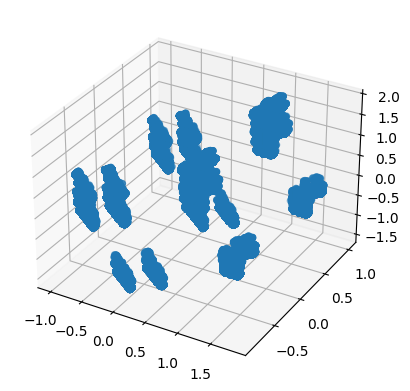

In [26]:
plt.clf()
ax = plt.axes(projection='3d')
ax.scatter3D(xs=components[0], ys=components[1], zs=components[2])
plt.show()

I could already see that transactions data is already separated to several clusters and at the first time I couldn't see anomalies from them. Now, I'm going to apply k-means to get these clusters' parameters.

### K-Means

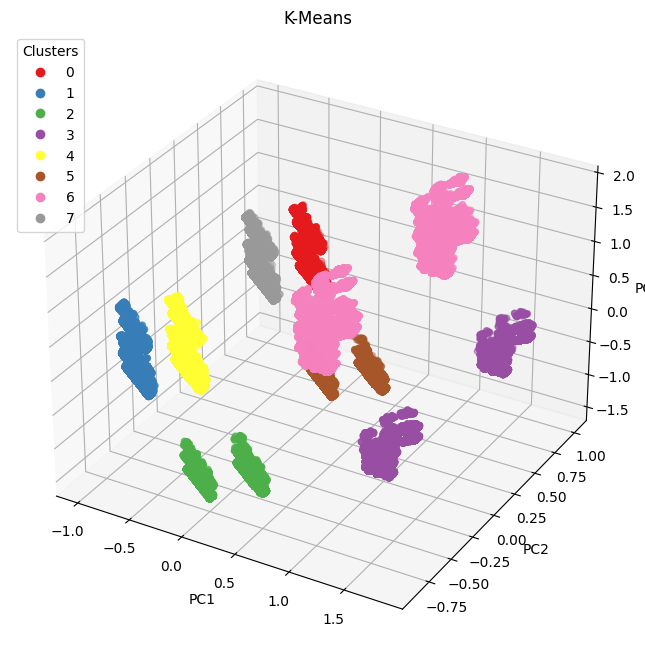

In [27]:
kmeans = KMeans(n_clusters=8, n_init=10)
pred = kmeans.fit_predict(trades_c_sc)
preds['kmeans_cluster'] = pred

components['kmeans_cluster'] = preds['kmeans_cluster']


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_title("K-Means")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')



scatter1 = ax.scatter3D(xs=components[0], ys=components[1], zs=components[2], c=components['kmeans_cluster'], cmap='Set1')
legend1 = ax.legend(*scatter1.legend_elements(),
                    title="Clusters", loc='upper left')
# ax.add_artist(legend1)

# plt.legend()
plt.show()

I guess 8 clusters is enough here because when I'm trying to increase them I'm getting worse separation.

Now I'm estimating LOF anomalies detectionm using PC.

### Local Outlier Factor

 1    1744430
-1        175
Name: lof_cluster, dtype: int64


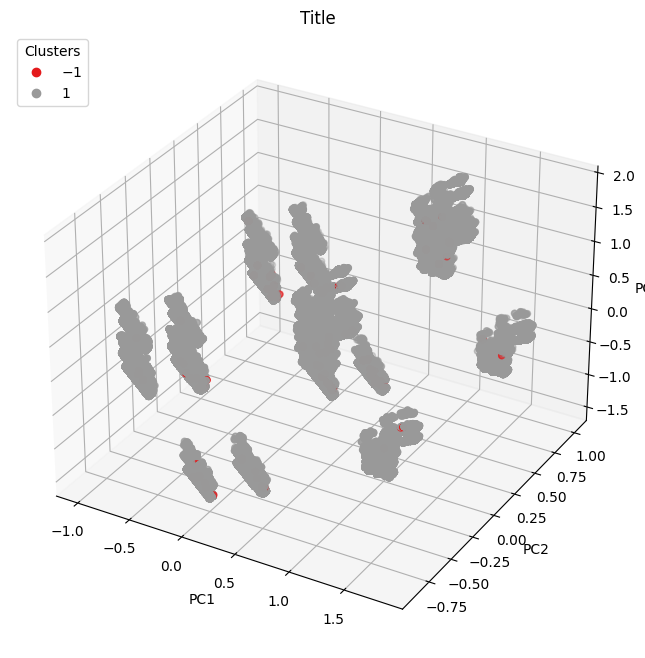

In [28]:
var_name = 'lof_cluster'
pred = LocalOutlierFactor(n_neighbors=10, n_jobs=-1, contamination=0.0001).fit_predict(components.filter(axis=1, regex='^\d*$'))
preds[var_name] = pred
print(preds[var_name].value_counts())

components[var_name] = preds[var_name]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.set_title("Title")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')



scatter1 = ax.scatter3D(xs=components[0], ys=components[1], zs=components[2], c=components[var_name], cmap='Set1')
legend1 = ax.legend(*scatter1.legend_elements(),
                    title="Clusters", loc='upper left')
# ax.add_artist(legend1)

# plt.legend()
plt.show()

I set too low level of contamination and relatively small amount of neighbors. That's because I'd like algorithm to separate very small group of probably fraudulent transactions (if they exist in the sample).

### Isolation Forest

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    1744430
-1        175
Name: iso_forest, dtype: int64


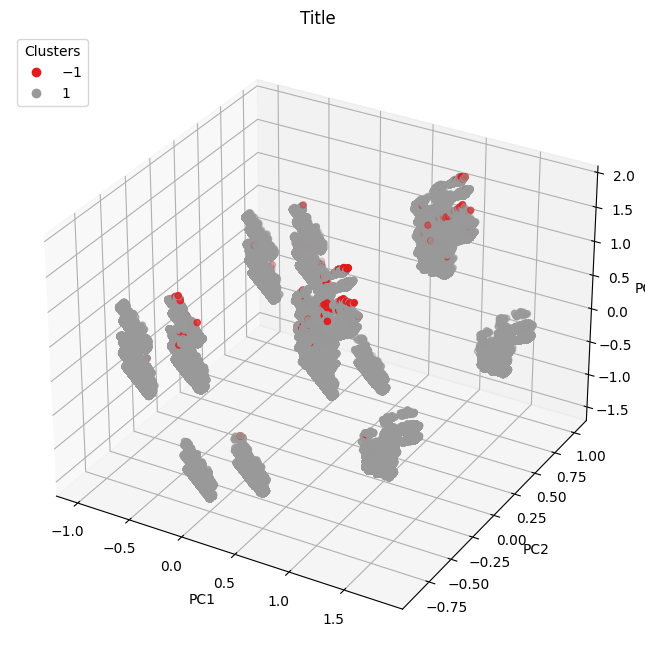

In [29]:
var_name = 'iso_forest'
iso_mod = IsolationForest(n_estimators=100, n_jobs=-1, contamination=0.0001)
pred = iso_mod.fit_predict(trades_c_sc)
preds[var_name] = pred
print(preds[var_name].value_counts())

components[var_name] = preds[var_name]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.set_title("Title")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')



scatter1 = ax.scatter3D(xs=components[0], ys=components[1], zs=components[2], c=components[var_name], cmap='Set1')
legend1 = ax.legend(*scatter1.legend_elements(),
                    title="Clusters", loc='upper left')
# ax.add_artist(legend1)

# plt.legend()
plt.show()

Then I'd like to compare LOF method to isolated forest and possibly select any kind of aggregating of these algorithms.

### Prediction analysis

Here I compare 3 algorithms that I used in this investigation

In [30]:
preds

,kmeans_cluster,lof_cluster,iso_forest
id,,,
9650033998,2,1,1
9650233695,2,1,1
15878019714,1,1,1
15878022975,1,1,1
15878030488,7,1,1
...,...,...,...
15919684995,6,1,1
15919701318,6,1,1
15920678026,7,1,1


In [31]:
trades_pred = trades_c.copy()
trades_pred[preds.columns] = preds
# trades_pred = trades_pred.merge(trades.set_index('id')[['user_id']], on='id').reset_index(drop=False)
# trades_pred = trades_pred.merge(devices.groupby('user_id', as_index=False)['device_id'].agg(pd.Series.nunique).rename(columns={'device_id':'device_cnt'}),
                                # on='user_id')
trades_pred.head()

,create_at,close_at,open_quote,close_quote,instrument_strike,initial_investment_enrolled,pnl_total_enrolled,trade_duration,option_duration,profitability,...,platform_Unknown platform,platform_WEB_MOBILE,platform_WebGL,platform_WinGL,create_at_dt,trade_freq,device_cnt,kmeans_cluster,lof_cluster,iso_forest
id,,,,,,,,,,,,,,,,,,,,,
9650033998,1.655394e+09,1.655394e+09,0.315245,0.314695,0.315245,0.79,0.690000,48.432,48.432,0.873418,...,0,0,0,1,1.655338e+09,-1.000,9,2,1,1
9650233695,1.655398e+09,1.655398e+09,0.316430,0.316460,0.316430,0.79,-0.790000,85.833,85.833,-1.000000,...,0,0,0,1,1.655338e+09,3862.599,9,2,1,1
15878019714,1.659473e+09,1.659473e+09,0.371500,0.372050,0.371500,3.00,-3.000000,51.262,51.262,-1.000000,...,0,0,0,0,1.659398e+09,-1.000,149,1,1,1
15878022975,1.659473e+09,1.659473e+09,0.371955,0.371495,0.371955,3.00,-0.018515,62.013,293.809,-0.006172,...,0,0,0,0,1.659398e+09,57.453,149,1,1,1
15878030488,1.659473e+09,1.659473e+09,0.371655,0.371385,0.371655,3.00,-3.000000,40.149,40.149,-1.000000,...,0,0,0,0,1.659398e+09,133.660,149,7,1,1


In [32]:
trades_pred.kmeans_cluster.value_counts().sort_values()

5    163505
2    167610
4    170130
0    172802
3    213328
6    247147
7    303997
1    306086
Name: kmeans_cluster, dtype: int64

Clusters aggregated information

In [36]:
res = {}
dg = trades_pred.reset_index().groupby(['kmeans_cluster', 'iso_forest'])
res['count'] = dg.id.count()

var_list = ["device_cnt", "trade_duration","option_duration", "trade_freq", "fin_instrument_BTCUSD",
            "fin_instrument_EOSUSD","fin_instrument_ETHUSD","fin_instrument_LTCUSD","fin_instrument_XRPUSD","instrument_type_digital-option",
            "instrument_type_turbo-option","instrument_direction_call","instrument_direction_put","close_reason_canceled","close_reason_expired",
            "close_reason_sold","platform_Android","platform_Android Facebook","platform_Android Vertical","platform_Android pwa for iqoption",
            "platform_CapitalBear.Android","platform_CapitalBear.AndroidX","platform_CapitalBear.WebGL","platform_CapitalBear.WinGL",
            "platform_Desktop Mobile","platform_Exnova.WebGL","platform_IOS pwa for iqoption","platform_IQ Option Wallet Web","platform_IQ Option X",
            "platform_Ios","platform_Ios CFD","platform_MacGL","platform_Unknown platform","platform_WEB_MOBILE","platform_WebGL","platform_WinGL"]

for x in ["initial_investment_enrolled","pnl_total_enrolled"]:
    res[x] = dg[x].sum()
res['profitability'] = res['pnl_total_enrolled'] / res['initial_investment_enrolled']

for x in var_list:
    res[x] = dg[x].mean()

res = pd.DataFrame(res)
res.transpose().to_excel('pred_stat.xlsx', merge_cells=False)
res

count  initial_investment_enrolled  \
kmeans_cluster iso_forest                                        
0              -1               4                 9.632082e+01   
                1          172798                 1.206376e+06   
1              -1               1                 1.730224e+00   
                1          306085                 1.568343e+06   
2              -1               1                 5.000000e-01   
                1          167609                 2.805734e+06   
3              -1               5                 8.314100e+02   
                1          213323                 7.294523e+05   
4              -1              12                 4.656257e+02   
                1          170118                 1.247706e+06   
5               1          163505                 2.821952e+06   
6              -1             150                 4.588759e+03   
                1          246997                 7.174045e+05   
7              -1               2                 2.971676e+02   
                1          303995                 1.485884e+06   

                           pnl_total_enrolled  profitability   device_cnt  \
kmeans_cluster iso_forest                                                   
0              -1                  -28.486931      -0.295751   592.250000   
                1               112724.467560       0.093441    72.188752   
1              -1                   -1.726993      -0.998133  1535.000000   
                1                68031.481513       0.043378    87.859885   
2              -1                   -0.490000      -0.980000    29.000000   
                1               435710.917867       0.155293   109.811925   
3              -1                  232.750000       0.279946   493.200000   
                1               -47515.434263      -0.065139   102.405179   
4              -1                 -314.721233      -0.675910   609.750000   
                1                89880.643103       0.072037    74.342439   
5               1               395690.249689       0.140219   102.542522   
6              -1                -2939.048412      -0.640489   522.453333   
                1               -19129.690264      -0.026665    95.162136   
7              -1                 -296.507613      -0.997779  2409.500000   
                1                16333.841167       0.010993    81.732413   

                           trade_duration  option_duration    trade_freq  \
kmeans_cluster iso_forest                                                  
0              -1              316.201000       664.151250  18092.858250   
                1               70.389069        74.011935    276.546510   
1              -1              714.405000       900.121000    831.930000   
                1               72.928285        76.134987    314.909258   
2              -1               32.062000        81.062000  69382.081000   
                1               63.769590        63.893306    281.207232   
3              -1              196.357400       230.557400  14233.018000   
                1               72.043718        72.320753    447.293259   
4              -1              559.077500       583.499000   6376.978750   
                1               72.512859        75.799727    281.877571   
5               1               62.577920        62.727090    286.481222   
6              -1              554.921173       683.265027   7559.194560   
                1              171.675980       183.835056    557.515509   
7              -1              720.533000       762.707500    388.529000   
                1               69.652482        73.081778    323.053973   

                           fin_instrument_BTCUSD  fin_instrument_EOSUSD  ...  \
kmeans_cluster iso_forest                                                ...   
0              -1                            0.0               0.000000  ...   
                1                            0.0              

In [34]:
res = {}
dg = trades_pred.reset_index().groupby(['iso_forest'])
res['count'] = dg.id.count()

var_list = ["device_cnt", "trade_duration","option_duration", "trade_freq", "fin_instrument_BTCUSD",
            "fin_instrument_EOSUSD","fin_instrument_ETHUSD","fin_instrument_LTCUSD","fin_instrument_XRPUSD","instrument_type_digital-option",
            "instrument_type_turbo-option","instrument_direction_call","instrument_direction_put","close_reason_canceled","close_reason_expired",
            "close_reason_sold","platform_Android","platform_Android Facebook","platform_Android Vertical","platform_Android pwa for iqoption",
            "platform_CapitalBear.Android","platform_CapitalBear.AndroidX","platform_CapitalBear.WebGL","platform_CapitalBear.WinGL",
            "platform_Desktop Mobile","platform_Exnova.WebGL","platform_IOS pwa for iqoption","platform_IQ Option Wallet Web","platform_IQ Option X",
            "platform_Ios","platform_Ios CFD","platform_MacGL","platform_Unknown platform","platform_WEB_MOBILE","platform_WebGL","platform_WinGL",]

for x in ["initial_investment_enrolled","pnl_total_enrolled"]:
    res['{}_sum'.format(x)] = dg[x].sum()
    res['{}_mean'.format(x)] = dg[x].mean()
res['profitability'] = res['pnl_total_enrolled_sum'] / res['initial_investment_enrolled_sum']

for x in var_list:
    res[x] = dg[x].mean()

res = pd.DataFrame(res)
res.transpose()
# res.transpose().to_excel('pred_stat.xlsx', merge_cells=False)


iso_forest,-1,1
count,175.000000,1.744430e+06
initial_investment_enrolled_sum,6281.513432,1.258285e+07
initial_investment_enrolled_mean,35.894362,7.213159e+00
pnl_total_enrolled_sum,-3348.231182,1.051726e+06
pnl_total_enrolled_mean,-19.132750,6.029055e-01
profitability,-0.533029,8.358411e-02
device_cnt,553.731429,9.021957e+01
trade_duration,539.321314,8.408895e+01
option_duration,661.758469,8.771000e+01
trade_freq,8142.460120,3.539446e+02


In [35]:
res = {}
dg = trades_pred.reset_index().groupby(['lof_cluster'])
res['count'] = dg.id.count()

var_list = ["device_cnt", "trade_duration","option_duration", "trade_freq", "fin_instrument_BTCUSD",
            "fin_instrument_EOSUSD","fin_instrument_ETHUSD","fin_instrument_LTCUSD","fin_instrument_XRPUSD","instrument_type_digital-option",
            "instrument_type_turbo-option","instrument_direction_call","instrument_direction_put","close_reason_canceled","close_reason_expired",
            "close_reason_sold","platform_Android","platform_Android Facebook","platform_Android Vertical","platform_Android pwa for iqoption",
            "platform_CapitalBear.Android","platform_CapitalBear.AndroidX","platform_CapitalBear.WebGL","platform_CapitalBear.WinGL",
            "platform_Desktop Mobile","platform_Exnova.WebGL","platform_IOS pwa for iqoption","platform_IQ Option Wallet Web","platform_IQ Option X",
            "platform_Ios","platform_Ios CFD","platform_MacGL","platform_Unknown platform","platform_WEB_MOBILE","platform_WebGL","platform_WinGL",]

for x in ["initial_investment_enrolled","pnl_total_enrolled"]:
    res[x] = dg[x].sum()
res['profitability'] = res['pnl_total_enrolled'] / res['initial_investment_enrolled']

for x in var_list:
    res[x] = dg[x].mean()

res = pd.DataFrame(res)
res.transpose()
# res.transpose().to_excel('pred_stat.xlsx', merge_cells=False)


lof_cluster,-1,1
count,175.000000,1.744430e+06
initial_investment_enrolled,1169.267361,1.258796e+07
pnl_total_enrolled,-200.046283,1.048578e+06
profitability,-0.171087,8.330007e-02
device_cnt,100.462857,9.026504e+01
trade_duration,246.683080,8.411831e+01
option_duration,259.691840,8.775034e+01
trade_freq,708.428651,3.546903e+02
fin_instrument_BTCUSD,0.262857,2.639424e-01
fin_instrument_EOSUSD,0.182857,3.370671e-02


LOF estimator as well as IsoForest separates group of highly unprofitable transactions that seems to be no fraudulent ones. As we can see from the EDA the majority of users usually make transactions pretty rarely, so there is nothing wrong with that fact that most of those transactions are unprofitable.

However, there is an interesting result in comparison IsoForest to K-means. We could see that most of the IsoForest "anomalies" generate negative profit except transactions in the 3rd K-means cluster. These 5 transactions instead generate highly positive profit which could possibly be an example of fraudulent users activity.

## Conclusion

After I've looked through the dataset I could make a summary of my findings in anomalies detection:
1. It's almost impossible to detect users with high amount of transactions whose behavior constantly differs from the others. This means that there are no regular fraud users.
2. I could find several suspicious transactions which are needed to be double-checked. Those transactions produced huge amount of profit in comparison to other similar transactions. Also I've found highly suspicious highly-profitable transactions made by traders who made one transaction during 3 months in total which are also should be double-checked.
3. Otherwise either the transactions and traders are pretty clear from anomalies.